In [445]:
%load_ext autoreload
%autoreload 2

import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [446]:
results_file = 'configurations/RS11_11_cluster5_4_merged.json'

# Loading Results

In [447]:
def json_results_to_dataframe(json_data):
    experiments = []
    metadata = json_data['metadata']

    for exp in json_data['experiments']:
        # Skip experiments with no results
        if exp['total_reward'] is None or exp['total_discounted_reward'] is None:
            continue

        # For each run in the experiment
        for run_idx, (total_reward, discounted_reward) in enumerate(zip(
            exp['total_reward'], exp['total_discounted_reward'])):

            exp_data = {
                'experiment_id': exp['experiment_id'],
                'env_instance_id': exp['env_instance_id'],
                'state_id': exp['state_id'],
                'help_config_id': exp['help_config_id'],
                'rover_position': str(exp['rover_position']),
                'rock_locations': str(exp['rock_locations']),
                'rock_types': str(exp['rock_types']),
                'help_actions': str(exp['help_actions']),
                'total_reward': total_reward,
                'total_discounted_reward': discounted_reward,
                'run_id': run_idx
            }
            experiments.append(exp_data)

    df = pd.DataFrame(experiments)
    return df, metadata

In [448]:
with open(results_file) as f:
    json_data = json.load(f)

df, metadata = json_results_to_dataframe(json_data)
df

,experiment_id,env_instance_id,state_id,help_config_id,rover_position,rock_locations,rock_types,help_actions,total_reward,total_discounted_reward,run_id
0,0,0,0,-1,"[0, 10]","{'(5, 4)': 0, '(2, 9)': 1, '(7, 4)': 2, '(9, 7...","['good', 'good', 'bad', 'bad', 'good', 'good',...",{},50.0,21.970854,0
1,0,0,0,-1,"[0, 10]","{'(5, 4)': 0, '(2, 9)': 1, '(7, 4)': 2, '(9, 7...","['good', 'good', 'bad', 'bad', 'good', 'good',...",{},50.0,21.473110,1
2,0,0,0,-1,"[0, 10]","{'(5, 4)': 0, '(2, 9)': 1, '(7, 4)': 2, '(9, 7...","['good', 'good', 'bad', 'bad', 'good', 'good',...",{},40.0,19.465957,2
3,1,0,0,0,"[0, 10]","{'(5, 4)': 0, '(2, 9)': 1, '(7, 4)': 2, '(9, 7...","['good', 'good', 'bad', 'bad', 'good', 'good',...","{'1': [0, -4], '7': [-5, -1], '10': [-1, -6]}",60.0,15.239265,0
4,1,0,0,0,"[0, 10]","{'(5, 4)': 0, '(2, 9)': 1, '(7, 4)': 2, '(9, 7...","['good', 'good', 'bad', 'bad', 'good', 'good',...","{'1': [0, -4], '7': [-5, -1], '10': [-1, -6]}",20.0,3.754686,1
...,...,...,...,...,...,...,...,...,...,...,...
9387,3625,5,8,0,"[0, 7]","{'(6, 8)': 0, '(8, 1)': 1, '(10, 6)': 2, '(2, ...","['bad', 'good', 'good', 'good', 'bad', 'good',...","{'5': [2, 3], '9': [0, 1], '3': [0, 3], '7': [...",20.0,10.388989,2
9388,3626,5,8,1,"[0, 7]","{'(6, 8)': 0, '(8, 1)': 1, '(10, 6)': 2, '(2, ...","['bad', 'good', 'good', 'good', 'bad', 'good',...","{'9': [1, -2], '5': [1, 0], '7': [-1, 0], '3':...",40.0,13.734238,0
9389,3626,5,8,1,"[0, 7]","{'(6, 8)': 0, '(8, 1)': 1, '(10, 6)': 2, '(2, ...","['bad', 'good', 'good', 'good', 'bad', 'good',...","{'9': [1, -2], '5': [1, 0], '7': [-1, 0], '3':...",20.0,10.808522,1
9390,3627,5,8,2,"[0, 7]","{'(6, 8)': 0, '(8, 1)': 1, '(10, 6)': 2, '(2, ...","['bad', 'good', 'good', 'good', 'bad', 'good',...","{'3': [0, 5], '9': [0, 4], '5': [2, 7], '7': [...",10.0,5.526907,0


In [449]:
instances_count = df.groupby('env_instance_id').agg({
    'state_id': 'nunique',
    'help_config_id': 'nunique'
}).reset_index()

# Check which instances have complete experiments (15 states and at least 10 help configs) (that's almost complete instances)
complete_instances = instances_count[
    (instances_count['state_id'] >= 20) &
    (instances_count['help_config_id'] >= 10)
]['env_instance_id'].tolist()

print(f"Number of instances: {len(instances_count)}")
print(f"Number of complete instances: {len(complete_instances)}")

# Filter for complete instances only
df_complete = df[df['env_instance_id'].isin(complete_instances)]

# Count experiments with less than 3 runs
experiment_runs = df_complete.groupby(['env_instance_id', 'state_id', 'help_config_id']).size().reset_index(name='run_count')

print(f"\nNumber of experiments with at least 3 runs: {len(experiment_runs[experiment_runs['run_count'] >= 3])}")
print(f"Number of experiments with less than 3 runs: {len(experiment_runs[experiment_runs['run_count'] < 3])}")
print(f"Number of experiments with less than 2 runs: {len(experiment_runs[experiment_runs['run_count'] < 2])}")
print(f"Number of experiments with less than 1 runs: {len(experiment_runs[experiment_runs['run_count'] < 1])}")

env_instances_ids = df_complete['env_instance_id'].unique()
print(f"complete instances: {env_instances_ids}")

Number of instances: 5
Number of complete instances: 3

Number of experiments with at least 3 runs: 2236
Number of experiments with less than 3 runs: 44
Number of experiments with less than 2 runs: 1
Number of experiments with less than 1 runs: 0
complete instances: [0 3 4]


In [450]:
# env_instances_to_analyze = [0,]
env_instances_to_analyze = env_instances_ids

df_complete = df_complete[df_complete['env_instance_id'].isin(env_instances_to_analyze)]

# Statistics

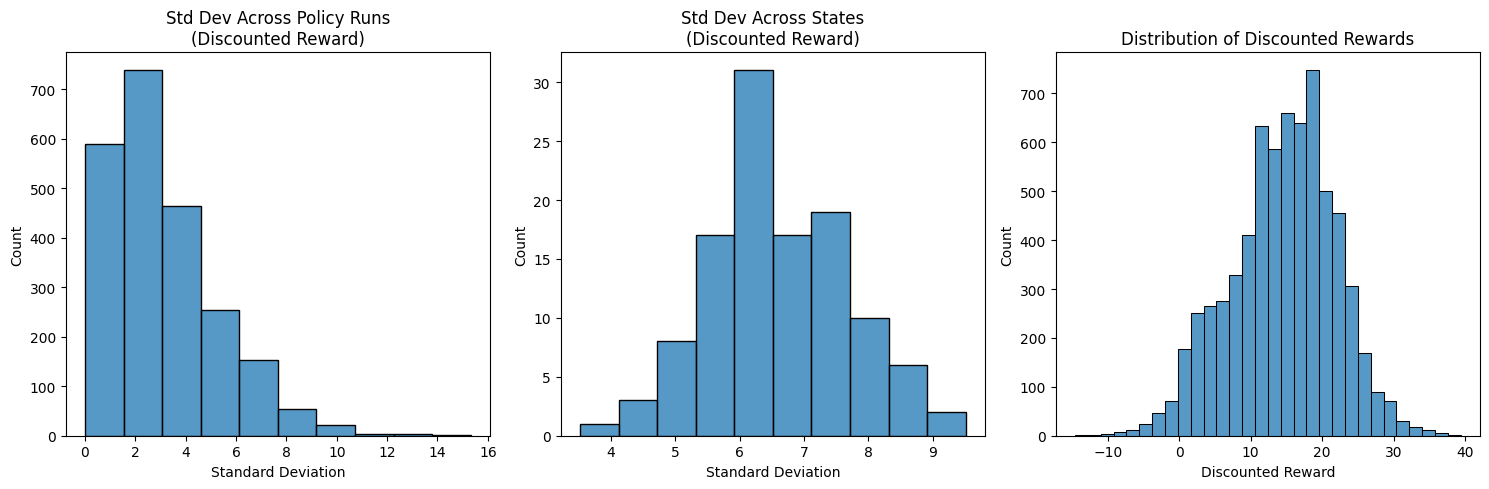


Policy StdDev Statistics (Discounted Reward):
count    2279.000000
mean        3.094443
std         2.124872
min         0.000000
25%         1.503852
50%         2.599329
75%         4.233542
max        15.319691
Name: policy_std, dtype: float64

State StdDev Statistics (Discounted Reward):
count    114.000000
mean       6.612520
std        1.125765
min        3.519708
25%        5.917324
50%        6.442474
75%        7.374090
max        9.516022
Name: state_std, dtype: float64

Ratio of mean state stddev to mean policy stddev: 2.14

Overall Discounted Reward Statistics:
count    6795.000000
mean       14.465662
std         7.313588
min       -14.607889
25%         9.997165
50%        14.986786
75%        19.437702
max        39.402543
Name: total_discounted_reward, dtype: float64


In [451]:
def analyze_discounted_stds():
   # Calculate std across runs for each (env_instance, help_config, state) combination
   policy_std = df_complete.groupby(['env_instance_id', 'help_config_id', 'state_id'])['total_discounted_reward'].std().reset_index(name='policy_std')

   # Calculate std across states for each (env_instance, help_config) combination
   state_std = df_complete.groupby(['env_instance_id', 'help_config_id'])['total_discounted_reward'].std().reset_index(name='state_std')

   # Create plots
   plt.figure(figsize=(15, 5))

   # Plot 1: Distribution of policy stds
   plt.subplot(131)
   sns.histplot(policy_std['policy_std'].dropna(), bins=10)
   plt.title('Std Dev Across Policy Runs\n(Discounted Reward)')
   plt.xlabel('Standard Deviation')

   # Plot 2: Distribution of state stds
   plt.subplot(132)
   sns.histplot(state_std['state_std'].dropna(), bins=10)
   plt.title('Std Dev Across States\n(Discounted Reward)')
   plt.xlabel('Standard Deviation')

   # Plot 3: Distribution of rewards
   plt.subplot(133)
   sns.histplot(df_complete['total_discounted_reward'], bins=30)
   plt.title('Distribution of Discounted Rewards')
   plt.xlabel('Discounted Reward')

   plt.tight_layout()
   plt.show()

   # Print statistics
   print("\nPolicy StdDev Statistics (Discounted Reward):")
   print(policy_std['policy_std'].describe())
   print("\nState StdDev Statistics (Discounted Reward):")
   print(state_std['state_std'].describe())

   # Calculate the ratio of standard deviations
   mean_policy_std = policy_std['policy_std'].mean()
   mean_state_std = state_std['state_std'].mean()
   print(f"\nRatio of mean state stddev to mean policy stddev: {mean_state_std/mean_policy_std:.2f}")

   print("\nOverall Discounted Reward Statistics:")
   print(df_complete['total_discounted_reward'].describe())

analyze_discounted_stds()

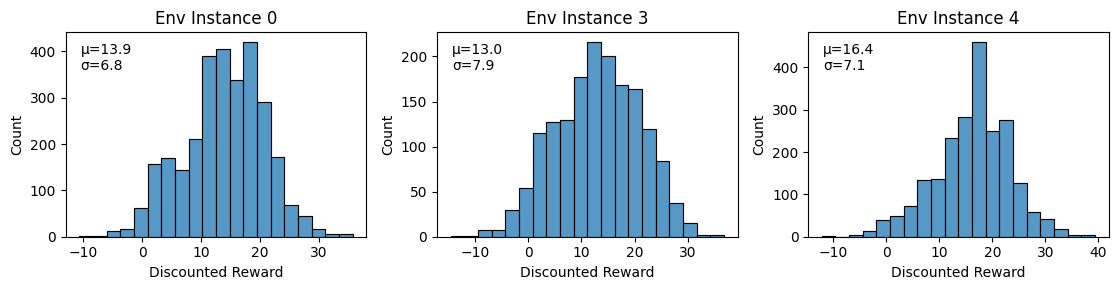


Summary statistics per environment:
                  count       mean       std        min        25%        50%  \
env_instance_id                                                                 
0                2930.0  13.870741  6.844751 -10.708805   9.722984  14.397531   
3                1659.0  12.986937  7.900723 -14.607889   7.114353  13.038920   
4                2206.0  16.367892  7.064145 -12.203702  12.139956  17.350434   

                       75%        max  
env_instance_id                        
0                18.687038  35.690375  
3                18.861293  36.775320  
4                21.202859  39.402543  


In [452]:
# Create a subplot grid based on number of environments
n_envs = len(env_instances_to_analyze)
n_cols = 4  # We can adjust this number to change layout
n_rows = (n_envs + n_cols - 1) // n_cols  # Ceiling division to get required rows

plt.figure(figsize=(15, 3*n_rows))

for idx, env_id in enumerate(env_instances_to_analyze):
    plt.subplot(n_rows, n_cols, idx + 1)
    env_data = df_complete[df_complete['env_instance_id'] == env_id]

    sns.histplot(data=env_data, x='total_discounted_reward', bins=20)
    plt.title(f'Env Instance {env_id}')
    plt.xlabel('Discounted Reward')

    # Add mean and std as text
    mean_reward = env_data['total_discounted_reward'].mean()
    std_reward = env_data['total_discounted_reward'].std()
    plt.text(0.05, 0.95, f'μ={mean_reward:.1f}\nσ={std_reward:.1f}',
             transform=plt.gca().transAxes,
             verticalalignment='top')

plt.tight_layout()
plt.show()

# Print summary statistics for each environment
print("\nSummary statistics per environment:")
print(df_complete.groupby('env_instance_id')['total_discounted_reward'].describe())

# Compute VD and VOA


Value Difference Statistics:
count    2220.000000
mean       -1.429150
std         5.050307
min       -21.422343
25%        -4.267523
50%        -1.109504
75%         1.572547
max        15.295781
Name: value_diff, dtype: float64

Empirical VOA Statistics:
count    111.000000
mean      -1.429150
std        2.917589
min       -9.879758
25%       -2.550848
50%       -1.046886
75%        0.536404
max        4.440079
Name: empirical_voa, dtype: float64


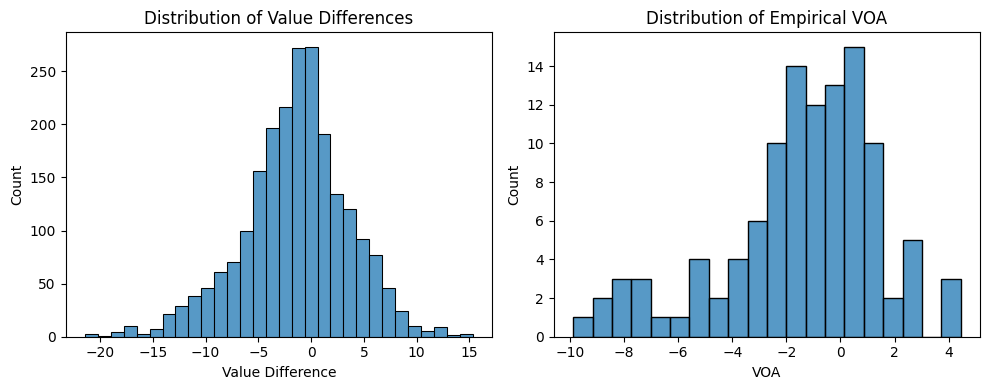


Value Difference Statistics:
count    2220.000000
mean       -1.429150
std         5.050307
min       -21.422343
25%        -4.267523
50%        -1.109504
75%         1.572547
max        15.295781
Name: value_diff, dtype: float64

VOA Statistics:
count    111.000000
mean      -1.429150
std        2.917589
min       -9.879758
25%       -2.550848
50%       -1.046886
75%        0.536404
max        4.440079
Name: empirical_voa, dtype: float64


In [453]:
def compute_value_differences(df):
    # First average across runs for each experiment configuration
    baseline_means = df[df['help_config_id'] == -1].groupby(
        ['env_instance_id', 'state_id'])['total_discounted_reward'].mean().reset_index()
    
    value_diff_results = []
    for _, baseline_row in baseline_means.iterrows():
        env_instance_id = baseline_row['env_instance_id']
        state_id = baseline_row['state_id']
        baseline_reward = baseline_row['total_discounted_reward']  # This is now mean across runs
        
        # Get mean rewards for help experiments while preserving help_actions
        help_exps = df[
            (df['env_instance_id'] == env_instance_id) &
            (df['state_id'] == state_id) &
            (df['help_config_id'] != -1)
        ].groupby(['env_instance_id', 'state_id', 'help_config_id']
        ).agg({
            'total_discounted_reward': 'mean',
            'help_actions': 'first'  # Since it's the same for all runs
        }).reset_index()
        
        for _, help_row in help_exps.iterrows():
            result_dict = help_row.to_dict()
            result_dict['value_diff'] = help_row['total_discounted_reward'] - baseline_reward
            result_dict['baseline_value'] = baseline_reward
            value_diff_results.append(result_dict)
            
    return pd.DataFrame(value_diff_results)

def compute_empirical_voa(vd_df):
    # Since states are sampled uniformly, we can just average over states
    # Group by env_instance_id and help_config_id
    voa_results = []

    for (env_id, help_config), group in vd_df.groupby(['env_instance_id', 'help_config_id']):
        # Compute mean value difference (VOA)
        empirical_voa = group['value_diff'].mean()
        # Compute variance
        empirical_variance = group['value_diff'].var()

        voa_results.append({
            'env_instance_id': env_id,
            'help_config_id': help_config,
            'help_actions': group['help_actions'].iloc[0],
            'empirical_voa': empirical_voa,
            'empirical_voa_variance': empirical_variance,
            'n_states': len(group),
            'baseline_value': group['baseline_value'].mean()
        })

    return pd.DataFrame(voa_results)

vd_df = compute_value_differences(df_complete)
voa_df = compute_empirical_voa(vd_df)

print("\nValue Difference Statistics:")
print(vd_df['value_diff'].describe())

print("\nEmpirical VOA Statistics:")
print(voa_df['empirical_voa'].describe())

plt.figure(figsize=(10, 4))

# Plot 1: Distribution of Value Differences
plt.subplot(121)
sns.histplot(vd_df['value_diff'], bins=30)
plt.title('Distribution of Value Differences')
plt.xlabel('Value Difference')
plt.ylabel('Count')

# Plot 2: Distribution of VOA
plt.subplot(122)
sns.histplot(voa_df['empirical_voa'], bins=20)
plt.title('Distribution of Empirical VOA')
plt.xlabel('VOA')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

# Print statistics
print("\nValue Difference Statistics:")
print(vd_df['value_diff'].describe())
print("\nVOA Statistics:")
print(voa_df['empirical_voa'].describe())

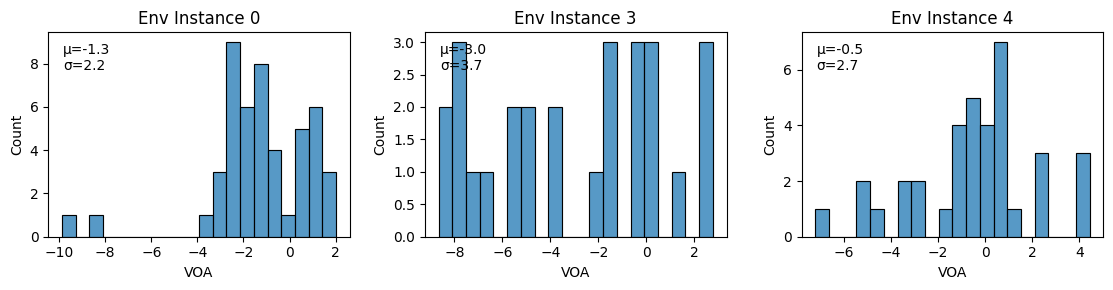


Summary statistics of VOA per environment:
                 count      mean       std       min       25%       50%  \
env_instance_id                                                            
0                 48.0 -1.277969  2.200116 -9.879758 -2.174035 -1.344993   
3                 27.0 -2.978921  3.729577 -8.654565 -6.082205 -2.170294   
4                 36.0 -0.468397  2.662026 -7.220847 -1.373670 -0.228856   

                      75%       max  
env_instance_id                      
0                0.397245  2.021548  
3                0.031311  2.773818  
4                0.737964  4.440079  


In [454]:
# Create a subplot grid based on number of environments
n_envs = len(env_instances_to_analyze)
n_cols = 4  # We can adjust this number to change layout
n_rows = (n_envs + n_cols - 1) // n_cols  # Ceiling division to get required rows

plt.figure(figsize=(15, 3*n_rows))

for idx, env_id in enumerate(env_instances_to_analyze):
   plt.subplot(n_rows, n_cols, idx + 1)
   env_data = voa_df[voa_df['env_instance_id'] == env_id]

   sns.histplot(data=env_data, x='empirical_voa', bins=20)
   plt.title(f'Env Instance {env_id}')
   plt.xlabel('VOA')

   # Add mean and std as text
   mean_voa = env_data['empirical_voa'].mean()
   std_voa = env_data['empirical_voa'].std()
   plt.text(0.05, 0.95, f'μ={mean_voa:.1f}\nσ={std_voa:.1f}',
            transform=plt.gca().transAxes,
            verticalalignment='top')

plt.tight_layout()
plt.show()

# Print summary statistics for each environment
print("\nSummary statistics of VOA per environment:")
print(voa_df.groupby('env_instance_id')['empirical_voa'].describe())

# Confidence

In [468]:
def plot_voa_with_standard_errors(voa_df):
    # Compute standard error
    voa_df['std_error'] = np.sqrt(voa_df['empirical_voa_variance'] / voa_df['n_states'])

    plt.figure(figsize=(10, 5))
    # Create labels for each env-help pair
    labels = [f"Env{row['env_instance_id']}-Help{row['help_config_id']}"
             for _, row in voa_df.iterrows()]

    plt.errorbar(range(len(voa_df)), voa_df['empirical_voa'],
                yerr=voa_df['std_error'], fmt='o', alpha=0.5)
    plt.xticks(range(len(voa_df)), labels, rotation=45)
    plt.xlabel('Environment-Help Configuration')
    plt.ylabel('VOA with Standard Error')
    plt.title('VOA with Standard Error Bars')
    plt.tight_layout()
    plt.show()


def plot_bootstrap_confidence_intervals(vd_df, n_bootstrap=1000):
   results = []
   ci_sizes = {'95': [], '90': [], '80': []}

   percentiles = {
       '95': [2.5, 97.5],
       '90': [5, 95],
       '80': [10, 90]
   }

   for (env_id, help_config), group in vd_df.groupby(['env_instance_id', 'help_config_id']):
       boots = [group['value_diff'].sample(n=len(group), replace=True).mean()
               for _ in range(n_bootstrap)]
       mean_voa = group['value_diff'].mean()

       # Calculate CIs for each confidence level
       cis = {}
       ci_size = {}
       for conf_level, percs in percentiles.items():
           ci_low, ci_high = np.percentile(boots, percs)
           cis[conf_level] = (ci_low, ci_high)
           ci_size[conf_level] = ci_high - ci_low
           ci_sizes[conf_level].append(ci_size[conf_level])

       results.append({
           'env_instance_id': env_id,
           'help_config_id': help_config,
           'voa': mean_voa,
           'ci_low_95': cis['95'][0],
           'ci_high_95': cis['95'][1],
           'ci_size_95': ci_size['95'],
           'ci_low_90': cis['90'][0],
           'ci_high_90': cis['90'][1],
           'ci_size_90': ci_size['90'],
           'ci_low_80': cis['80'][0],
           'ci_high_80': cis['80'][1],
           'ci_size_80': ci_size['80']
       })

   results_df = pd.DataFrame(results)

   # Print statistics for each confidence level
   for conf_level in ['95', '90', '80']:
       print(f"\n{conf_level}% Confidence Interval Size Statistics:")
       print(f"Mean CI size: {np.mean(ci_sizes[conf_level]):.2f}")
       print(f"Median CI size: {np.median(ci_sizes[conf_level]):.2f}")
       print(f"Std of CI sizes: {np.std(ci_sizes[conf_level]):.2f}")
       print(f"Min CI size: {np.min(ci_sizes[conf_level]):.2f}")
       print(f"Max CI size: {np.max(ci_sizes[conf_level]):.2f}")

   # Plot with all confidence levels
   plt.figure(figsize=(12, 6))
   labels = [f"Env{row['env_instance_id']}-Help{row['help_config_id']}"
            for _, row in results_df.iterrows()]

   # Plot different confidence intervals with different colors/styles
   plt.errorbar(range(len(results_df)), results_df['voa'],
               yerr=[results_df['voa'] - results_df['ci_low_95'],
                     results_df['ci_high_95'] - results_df['voa']],
               fmt='o', alpha=0.3, color='blue', label='95% CI')
   plt.errorbar(range(len(results_df)), results_df['voa'],
               yerr=[results_df['voa'] - results_df['ci_low_90'],
                     results_df['ci_high_90'] - results_df['voa']],
               fmt='o', alpha=0.5, color='green', label='90% CI')
   plt.errorbar(range(len(results_df)), results_df['voa'],
               yerr=[results_df['voa'] - results_df['ci_low_80'],
                     results_df['ci_high_80'] - results_df['voa']],
               fmt='o', alpha=0.7, color='red', label='80% CI')

   plt.xticks(range(len(results_df)), labels, rotation=45)
   plt.xlabel('Environment-Help Configuration')
   plt.ylabel('VOA with CIs')
   plt.title('VOA with Different Confidence Intervals')
   plt.legend()
   plt.tight_layout()
   plt.show()

   return results_df, ci_sizes

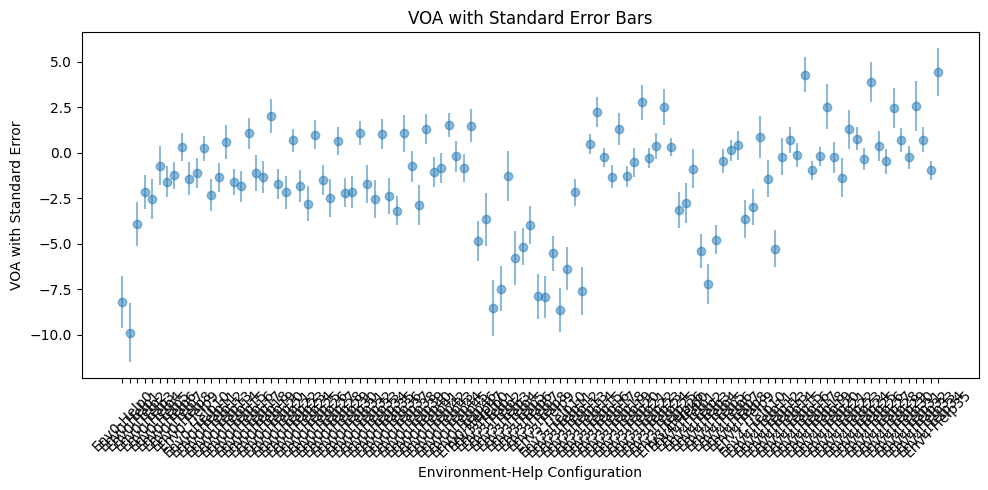

In [463]:
# Plot standard error visualization
plot_voa_with_standard_errors(voa_df)


95% Confidence Interval Size Statistics:
Mean CI size: 3.48
Median CI size: 3.39
Std of CI sizes: 0.90
Min CI size: 1.86
Max CI size: 6.13

90% Confidence Interval Size Statistics:
Mean CI size: 2.93
Median CI size: 2.88
Std of CI sizes: 0.76
Min CI size: 1.53
Max CI size: 5.17

80% Confidence Interval Size Statistics:
Mean CI size: 2.29
Median CI size: 2.20
Std of CI sizes: 0.58
Min CI size: 1.18
Max CI size: 4.00


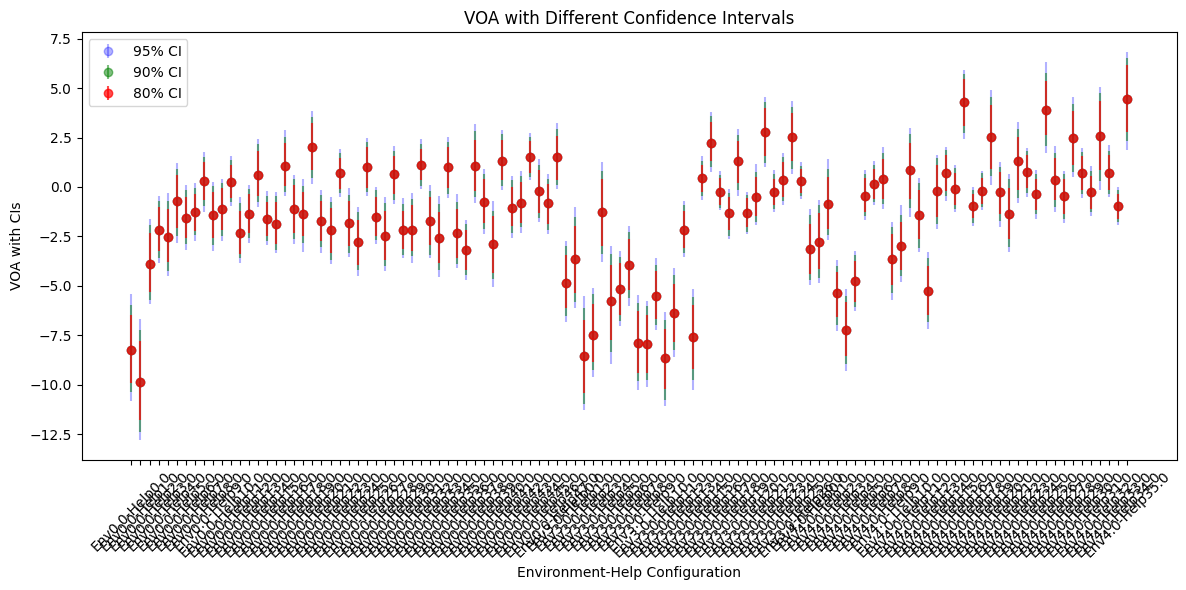

In [469]:
# Plot and get bootstrap CI visualization
bootstrap_results, ci_sizes = plot_bootstrap_confidence_intervals(vd_df, n_bootstrap=1000)

In [470]:
for conf_level in ['95', '90', '80']:
    print(f"\n{conf_level}% Confidence Interval Size Statistics:")
    print(f"Mean CI size: {np.mean(ci_sizes[conf_level]):.2f}")
    print(f"Median CI size: {np.median(ci_sizes[conf_level]):.2f}")
    print(f"Std of CI sizes: {np.std(ci_sizes[conf_level]):.2f}")
    print(f"Min CI size: {np.min(ci_sizes[conf_level]):.2f}")
    print(f"Max CI size: {np.max(ci_sizes[conf_level]):.2f}")


95% Confidence Interval Size Statistics:
Mean CI size: 3.48
Median CI size: 3.39
Std of CI sizes: 0.90
Min CI size: 1.86
Max CI size: 6.13

90% Confidence Interval Size Statistics:
Mean CI size: 2.93
Median CI size: 2.88
Std of CI sizes: 0.76
Min CI size: 1.53
Max CI size: 5.17

80% Confidence Interval Size Statistics:
Mean CI size: 2.29
Median CI size: 2.20
Std of CI sizes: 0.58
Min CI size: 1.18
Max CI size: 4.00


# Experimenting and debugging:

In [459]:
vd_df

,env_instance_id,state_id,help_config_id,total_discounted_reward,help_actions,value_diff,baseline_value
0,0,0,0,9.875327,"{'1': [0, -4], '7': [-5, -1], '10': [-1, -6]}",-11.094647,20.969974
1,0,0,1,6.076562,"{'10': [-1, -8], '7': [-5, -4], '1': [0, -8]}",-14.893412,20.969974
2,0,0,2,8.862165,"{'10': [-1, -2], '7': [-5, 2], '1': [0, -2]}",-12.107809,20.969974
3,0,0,3,18.929074,"{'0': [-3, 1], '2': [-6, 1], '7': [-4, -2], '6...",-2.040900,20.969974
4,0,0,4,20.427336,"{'2': [-5, -2], '7': [-5, -4], '6': [-3, -2], ...",-0.542638,20.969974
...,...,...,...,...,...,...,...
2215,4,19,31,21.657521,"{'8': [-7, 0], '3': [-5, 1], '5': [-8, 1], '10...",-1.852432,23.509954
2216,4,19,32,29.294975,"{'5': [-9, 8], '10': [-5, 6], '3': [-4, 6], '8...",5.785021,23.509954
2217,4,19,33,22.880997,"{'10': [-5, 2], '8': [-8, 3], '5': [-8, 6], '7...",-0.628957,23.509954
2218,4,19,34,20.443659,"{'7': [-6, 1], '5': [-9, 2], '10': [-5, -2], '...",-3.066295,23.509954


In [460]:
# show 5 most beneficial actions:
voa_df.sort_values('empirical_voa', ascending=False).head(5)

,env_instance_id,help_config_id,help_actions,empirical_voa,empirical_voa_variance,n_states,baseline_value,std_error
110,4,35,"{'8': [-8, 6], '10': [-5, 6], '7': [-6, 6], '5...",4.440079,34.848665,20,16.813592,1.320013
92,4,17,"{'10': [-6, 5], '3': [-4, 8], '8': [-7, 5], '7...",4.296632,18.338314,20,16.813592,0.957557
101,4,26,"{'8': [-8, 6], '5': [-8, 9], '3': [-4, 6], '7'...",3.905486,24.430284,20,16.813592,1.105221
70,3,22,"{'3': [-7, -4], '5': [-7, 0]}",2.773818,17.962493,20,15.869090,0.947694
107,4,32,"{'5': [-9, 8], '10': [-5, 6], '3': [-4, 6], '8...",2.572364,36.716056,20,16.813592,1.354918


In [461]:
import pomdp_py
from rocksample_experiments.rocksample_problem import RockSampleProblem, State

# take vd at idx:
entry = vd_df.iloc[1]

# visualize the problem:
rocklocs = eval(vd_df.iloc[7]['rock_locations'])
rocklocs = {eval(k): v for k, v in rocklocs.items()}
init_state = State(position = tuple(eval(entry['rover_position'])), rocktypes = tuple(eval(entry['rock_types'])), terminal=False)

# Create initial belief
with open(f'configurations/particles_k11.json', 'r') as f:
    rocktypes = json.load(f)
particles = [State(position=init_state.position, rocktypes=rocktypes[i], terminal=False)
             for i in range(1000)]
init_belief = pomdp_py.Particles(particles)

problem = RockSampleProblem(n=11, k=11, init_state=init_state, rock_locs=rocklocs, init_belief=init_belief)

KeyError: 'rock_locations'

In [ ]:
problem.print_state()

In [ ]:
from rocksample_experiments.help_actions import push_rocks

help = eval(entry['help_actions'])
help = {eval(k): v for k, v in help.items()}

problem_with_help, _ = push_rocks(problem, help)
problem_with_help.print_state()

In [ ]:
# do the same with helping action 25, find vd where help_config_id = 25
help = eval(voa_df[voa_df['help_config_id'] == 20].iloc[0]['help_actions'])
help = {eval(k): v for k, v in help.items()}

problem_with_help, _ = push_rocks(problem, help)
problem_with_help.print_state()